In [11]:
'''
Sources =>
ES reference 
https://github.com/alirezamika/evostra/blob/master/evostra/algorithms/evolution_strategy.py
 
A2C reference
https://github.com/MorvanZhou/Reinforcement-learning-with-tensorflow/
'''
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import random
import gym
import math
import matplotlib.pyplot as plt
from gym.wrappers.monitor import Monitor
import time

In [12]:
device_name = "/gpu:0"

In [13]:
'''
Softmax for fitness 
'''
def softmax(x):
    ex = np.exp(x-np.max(x))
    return ex/ex.sum()

In [14]:
'''
Rank population based on fitness score
'''
def fitness(env, w0, w1):
    total_reward = 0.0
    num_run = 1
    
    # calculate weight that is expected to give maximum reward 
    # over time
    for t in range(num_run):
        observation = env.reset()
        for i in range(200):
            p0 = np.dot(w0, observation)
            p1 = np.dot(w1, observation)
            joint = [p0, p1]
            softmax_p = softmax(joint)
            
            #print (softmax_p)
            action = 0 if random.uniform(0,1) < softmax_p[0] else 1
            observation, reward, done, info = env.step(action)

            total_reward += reward
            if done:
                break
    return total_reward / num_run

In [15]:
'''
Tournament selection 
'''
def evolution_strategy(env, weight, policy_grad, value_grad, sess):
    # sample from population
    population_size = 50 
    
    # jitter weights using noise std dev
    noise = 0.1 
    
    # fitness fun
    reward = fitness(env, weight[:,0], weight[:,1])
    
    # sample from normal distribution
    N = np.random.randn(population_size, 4,2) 
    R = np.zeros(population_size)
    
    maxReward = 0
    maxWeight = weight
    
    with tf.device(device_name):
        for j in range(population_size):
            
            # jitter the weight using the gaussian
            noise_weight = weight + noise * N[j,:,:]
            assign_params(policy_grad, sess, noise_weight)

            for i in range(5):
                run_episode(env, policy_grad, value_grad, sess)

            with tf.variable_scope("policy", reuse = tf.AUTO_REUSE):
                weight_tf = tf.get_variable("policy_parameters",[4,2], dtype = tf.float64)

            resWeights = weight_tf.eval()
            weight0 = resWeights[:,0]
            weight1 = resWeights[:,1]
            
            # get reward from the jittered version
            R[j] = fitness(env, weight0, weight1) 

            if R[j] > maxReward:
                maxReward = R[j]
                maxWeight = resWeights

    return maxWeight, reward

In [16]:
'''
Policy estimation
'''
def policyGradient():
    with tf.variable_scope("policy", reuse = tf.AUTO_REUSE):
        params = tf.get_variable("policy_parameters",[4,2], dtype = tf.float64)
        
        c = tf.placeholder("float64", [4, 2])
        s = tf.placeholder("float64", [None, 4])
        a = tf.placeholder("float64", [None, 2])
        adv = tf.placeholder("float64", [None, 1])
        
        with tf.device(device_name):
            #linear layer
            linear = tf.matmul(s, params)
            p = tf.nn.softmax(linear)
            
            #print p.get_shape()
            
            p_res = tf.reduce_sum(tf.multiply(p, a), reduction_indices=[1])
            eligibility = tf.log(p_res) * adv
            
            #print p_res.get_shape()
            
            
            loss = -tf.reduce_sum(eligibility)
            optimizer = tf.train.AdamOptimizer(0.01).minimize(loss)

            params_assign = params.assign(c)

        return p, s, a, adv, optimizer, c, params_assign

In [17]:
'''
Gradient estimation
'''
def valueGradient():
    with tf.variable_scope("value"):
        with tf.device(device_name):
            state = tf.placeholder("float",[None,4])
            res = tf.placeholder("float",[None,1])
            
            #l1
            w1 = tf.get_variable("w1",[4,10])
            b1 = tf.get_variable("b1",[10])
            
            #hidden
            h1 = tf.nn.relu(tf.matmul(state,w1) + b1)
            
            #l2
            w2 = tf.get_variable("w2",[10,1])
            b2 = tf.get_variable("b2",[1])

            out = tf.matmul(h1, w2) + b2
            error = out - res
            loss = tf.nn.l2_loss(error)

            optimizer = tf.train.AdamOptimizer(0.1).minimize(loss)
        return out, state, res, optimizer, loss

In [18]:
def assign_params(policy_grad, sess, w_try):
    pl_calculated, pl_state, pl_actions, pl_advantages, pl_optimizer, c, params_assign = policy_grad
    sess.run(params_assign, feed_dict={c: w_try})

In [19]:
def run_episode(env, policyGrad, valueGrad, sess):
    pl_calculated, pl_state, pl_actions, pl_advantages, pl_optimizer, c, params_assign = policyGrad
    vl_calculated, vl_state, vl_newvals, vl_optimizer, vl_loss = valueGrad
    
    observation = env.reset()
    total_reward = 0
    
    states = []
    actions = []
    advantages = []
    transitions = []
    updatedValues = []

    for _ in range(200):

        # get the policy 
        observationList = np.expand_dims(observation, axis=0)
        probs = sess.run(pl_calculated,feed_dict={pl_state: observationList})
        action = 0 if random.uniform(0,1) < probs[0][0] else 1

        # get transition
        states.append(observation)
        actionChoice = np.zeros(2)
        actionChoice[action] = 1
        actions.append(actionChoice)

        # move in the environment
        previousObservations = observation
        observation, reward, done, info = env.step(action)

        transitions.append((previousObservations, action, reward))
        total_reward += reward

        if done:
            break
    
    for i, t in enumerate(transitions):
        obs, action, reward = t

        # get discounted monte-carlo return 
        newReward = 0
        newTransitions = len(transitions) - i
        decrease = 1
        
        for j in range(newTransitions):
            newReward += transitions[(j) + i][2] * decrease
            decrease = decrease * 0.97
        
        observationList = np.expand_dims(obs, axis=0)
        currentval = sess.run(vl_calculated,feed_dict={vl_state: observationList})[0][0]

        advantages.append(newReward - currentval)
        updatedValues.append(newReward)

    # save state for updated 
    updatedValuesList = np.expand_dims(updatedValues, axis=1)
    sess.run(vl_optimizer, feed_dict={vl_state: states, vl_newvals: updatedValuesList})

    advantagesList = np.expand_dims(advantages, axis=1)
    sess.run(pl_optimizer, feed_dict={pl_state: states, pl_advantages: advantagesList, pl_actions: actions})
    
    return total_reward

/opt/conda/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


0 10.0
1 12.0
2 43.0
3 16.0
4 22.0
5 9.0
6 15.0
7 15.0
8 35.0
9 20.0
10 30.0
11 13.0
12 24.0
13 35.0
14 35.0
15 29.0
16 11.0
17 39.0
18 35.0
19 18.0
20 35.0
21 103.0
22 38.0
23 64.0
24 17.0
25 116.0
26 57.0
27 88.0
28 25.0
29 28.0
30 38.0
31 95.0
32 92.0
33 141.0
34 110.0
35 46.0
36 70.0
37 199.0
38 168.0
39 35.0
40 76.0
41 134.0
42 56.0
43 117.0
44 200.0
45 145.0
46 200.0
47 52.0
48 60.0
49 28.0
50 36.0
51 200.0
52 157.0
53 124.0
54 109.0
55 100.0
56 83.0
57 200.0
58 84.0
59 147.0
60 200.0
61 200.0
62 193.0
63 181.0
64 127.0
65 48.0
66 191.0
67 200.0
68 200.0
69 148.0
70 87.0
71 174.0
72 200.0
73 186.0
74 147.0
75 200.0
76 184.0
77 200.0
78 200.0
79 200.0
80 200.0
81 118.0
82 200.0
83 115.0
84 146.0
85 200.0
86 200.0
87 200.0
88 200.0
89 200.0
90 123.0
91 200.0
92 200.0
93 200.0
94 200.0
95 200.0
96 149.0
97 200.0
98 200.0
99 200.0
100 200.0
101 156.0
102 193.0
103 184.0
104 200.0
105 200.0
106 200.0
107 200.0
108 158.0
109 143.0
110 200.0
111 200.0
112 130.0
113 158.0
114 172.0
115 1

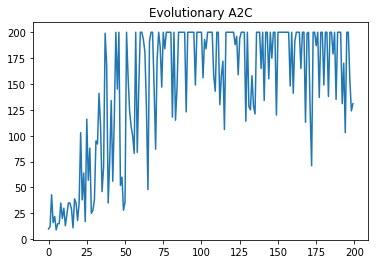

In [20]:
'''
Test network on cartpole
'''

cartpoleRewards = np.zeros(200)

for i in range(1):
    env = gym.make('CartPole-v0')
    monitor = Monitor(env,'cartpole-hill/', force=True)
    tf.reset_default_graph() 
    
    pG = policyGradient()
    vG = valueGradient()
    
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    
    with tf.variable_scope("policy", reuse = tf.AUTO_REUSE):
        weight = tf.get_variable("policy_parameters", [4,2], dtype = tf.float64).eval()
    
    for i in range(200):
        weight, reward = evolution_strategy(env, weight, pG, vG, sess)
        print(i, reward)

        cartpoleRewards[i] = reward

    sess.close()
    monitor.close()
    env.close()

plt.title("Evolutionary A2C")
plt.plot(cartpoleRewards)

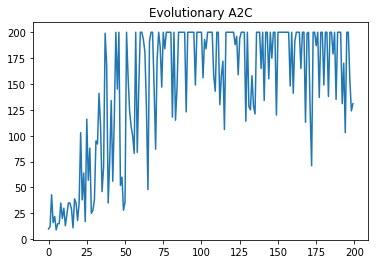

In [21]:
plt.title("Evolutionary A2C")
plt.plot(cartpoleRewards)